In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box

def plot_block_with_population_housing_and_buildings(
    blocks_gdf: gpd.GeoDataFrame,
    target_geoid20: str,
    title: str = "Census Block with Population/Housing Data"
) -> None:
    """
    Plots a specific census block, its population and housing data,
    and an OpenStreetMap basemap which includes building outlines.

    Args:
        blocks_gdf (gpd.GeoDataFrame): GeoDataFrame containing census blocks.
                                       Must include 'GEOID20', 'POP20',
                                       and 'HOUSING20' columns.
        target_geoid20 (str): The GEOID20 of the block to plot.
        title (str, optional): The title for the plot.
                               Defaults to "Census Block with Population/Housing Data".
    """
    # Ensure GEOID20 column is string type for matching
    if 'GEOID20' not in blocks_gdf.columns:
        print("Error: 'GEOID20' column not found in GeoDataFrame.")
        return
    
    blocks_gdf['GEOID20'] = blocks_gdf['GEOID20'].astype(str)
    target_geoid20 = str(target_geoid20)

    # Filter for the target block
    target_block = blocks_gdf[blocks_gdf['GEOID20'] == target_geoid20]

    if target_block.empty:
        print(f"Block with GEOID20 '{target_geoid20}' not found.")
        return

    # Ensure POP20 and HOUSING20 columns exist
    if 'POP20' not in target_block.columns or 'HOUSING20' not in target_block.columns:
        print("Error: 'POP20' or 'HOUSING20' columns not found for the selected block.")
        return

    # Get population and housing data
    population = target_block['POP20'].iloc[0]
    housing_units = target_block['HOUSING20'].iloc[0]

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    # Plot the target block
    # Use a contrasting color and some transparency to see basemap
    target_block.to_crs(epsg=3857).plot(
        ax=ax,
        alpha=0.5,
        edgecolor='red',
        facecolor='yellow',
        linewidth=2,
        label=f"Block {target_geoid20}"
    )

    # Add basemap from OpenStreetMap (often shows buildings)
    # Adjust zoom level if needed, or let contextily auto-determine
    try:
        ctx.add_basemap(
            ax,
            crs=target_block.to_crs(epsg=3857).crs.to_string(),
            source=ctx.providers.OpenStreetMap.Mapnik, # This source usually has building footprints
            zoom='auto' # Let contextily determine zoom from bounds, or set manually e.g. 18
        )
    except Exception as e:
        print(f"Could not add basemap: {e}")


    # Add text annotation for population and housing
    # Get centroid of the block for placing the text
    # Ensure the geometry is not empty and is valid
    if not target_block.geometry.iloc[0].is_empty and target_block.geometry.iloc[0].is_valid:
        centroid = target_block.geometry.iloc[0].centroid
        
        # Project centroid to the plot's CRS (EPSG:3857) for correct annotation placement
        centroid_map_crs = gpd.GeoSeries([centroid], crs=target_block.crs).to_crs(epsg=3857).iloc[0]

        ax.annotate(
            text=f"GEOID: {target_geoid20}\nPopulation (POP20): {population}\nHousing Units (HOUSING20): {housing_units}",
            xy=(centroid_map_crs.x, centroid_map_crs.y),
            xytext=(5, 5),  # Offset text slightly
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7),
            fontsize=9
        )
    else:
        print(f"Warning: Geometry for block {target_geoid20} is empty or invalid. Cannot place annotation.")

    ax.set_title(title)
    ax.set_axis_off()
    plt.legend()
    plt.show()


In [3]:
# Example: Load your blocks data
filepath_gdf = "/Users/magic-rabbit/Documents/00_Tech-Repositories/05_MASTER_THESIS/SynGrid/syngrid/data_processor/output/MA/Middlesex_County/Cambridge_city/Census/25_017_11000_blocks.geojson"
blocks_data = gpd.read_file(filepath_gdf)

/var/folders/65/9j_wpsj10wdgptqdmzhrcwqm0000gn/T/ipykernel_93683/624055650.py:96: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/65/9j_wpsj10wdgptqdmzhrcwqm0000gn/T/ipykernel_93683/624055650.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


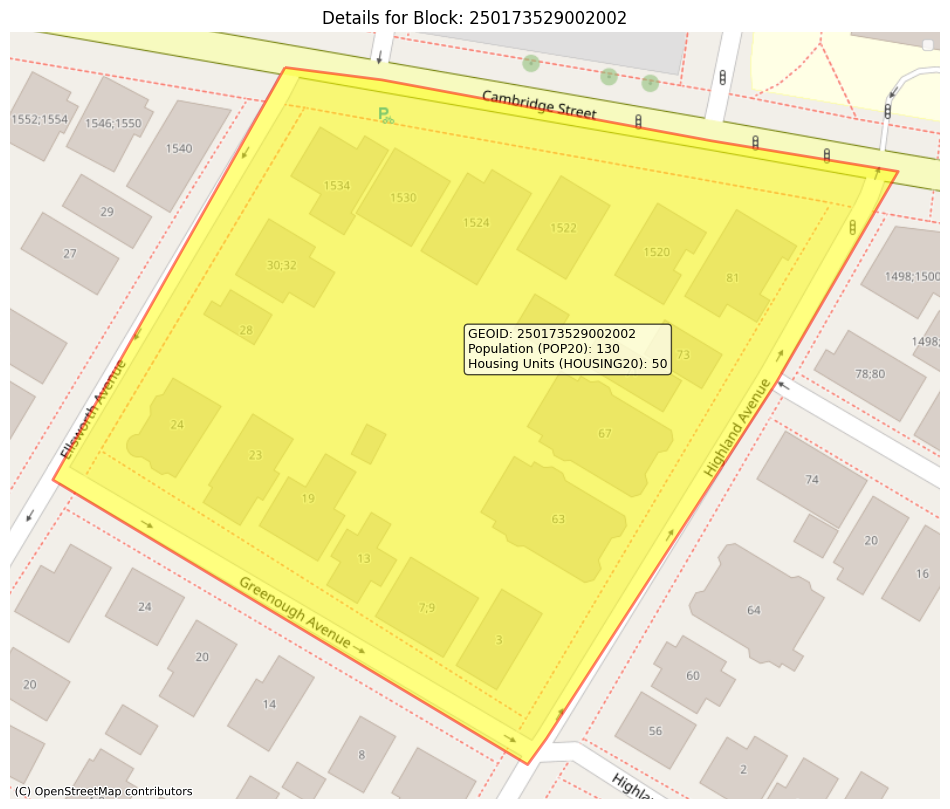

In [6]:
# Replace 'YOUR_GEOID20_HERE' with the actual GEOID20 of the block you want to see
# For example, using one from your provided context:
example_geoid = "250173529002002" 

plot_block_with_population_housing_and_buildings(
    blocks_gdf=blocks_data,
    target_geoid20=example_geoid,
    title=f"Details for Block: {example_geoid}"
)